# **AI Music Generation using Recurrent Neural Networks**

### **Setup**

Installing necessary modules and packages required. We will use the ```pretty_midi``` library to create and parse MIDI files, and ```pyfluidsynth``` for generating audio playback

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.7 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=27ae88428aace0df548358113ce2d7577b0d1e62449c52b950a14e76e110665d
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

### **Dataset**

Downlaod the Maestro Dataset which contains about 1200 MIDI files

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


### **Process a MIDI file**

```pretty_midi``` will parse a single MIDI file & inspect the format of notes

In [ ]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--4.midi


Generate a ```PrettyMIDI``` object for the sample MIDI file

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play sample file

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Inspect the MIDI file and display information like details of instruments used

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### **Extract Notes**

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=24, note_name=C1, duration=0.1250
1: pitch=36, note_name=C2, duration=0.1615
2: pitch=48, note_name=C3, duration=0.1667
3: pitch=34, note_name=A#1, duration=0.0495
4: pitch=43, note_name=G2, duration=0.0964
5: pitch=31, note_name=G1, duration=0.1055
6: pitch=55, note_name=G3, duration=0.0742
7: pitch=41, note_name=F2, duration=0.0495
8: pitch=29, note_name=F1, duration=0.0417
9: pitch=53, note_name=F3, duration=0.0612


```pitch```, ```step``` & ```duration``` are the 3 variables used to represent a note during training of the model. 
- ```pitch``` is the perceptual quality of the sound as a MIDI note number.
- ```step``` is the time elapsed from the previous note or start of the track.
- ```duration``` is how long the note is played (in seconds) i.e difference between note end & note start times.

Now extract the notes from the sample MIDI file

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,36,0.967448,1.128906,0.000000,0.161458
1,24,0.971354,1.096354,0.003906,0.125000
2,48,1.140625,1.307292,0.169271,0.166667
3,43,1.263021,1.359375,0.122396,0.096354
4,31,1.274740,1.380208,0.011719,0.105469


The function below will be used to change from the numeric pitch values to note names since it could be simpler to understand the note names than the pitches.
The note's name includes information about its octave, accidental, and note type. 

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C2', 'C1', 'C3', 'G2', 'G1', 'A#1', 'G3', 'F2', 'F1', 'F3'],
      dtype='<U3')

Starting with the first 100 notes, plot the note pitch, start and end across the length of the track(i.e piano roll) to visualize the musical piece

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

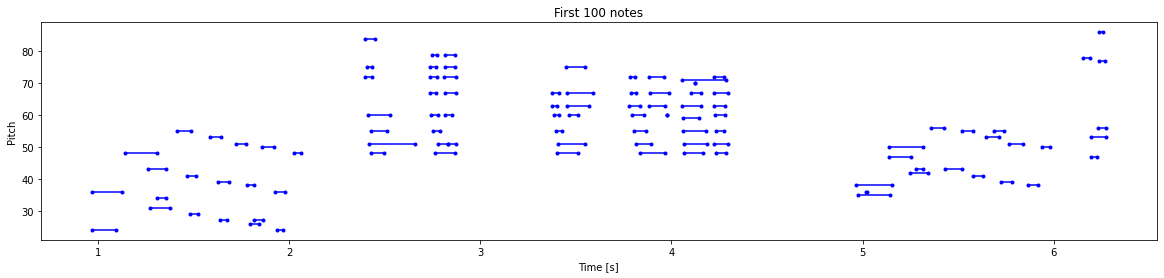

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track

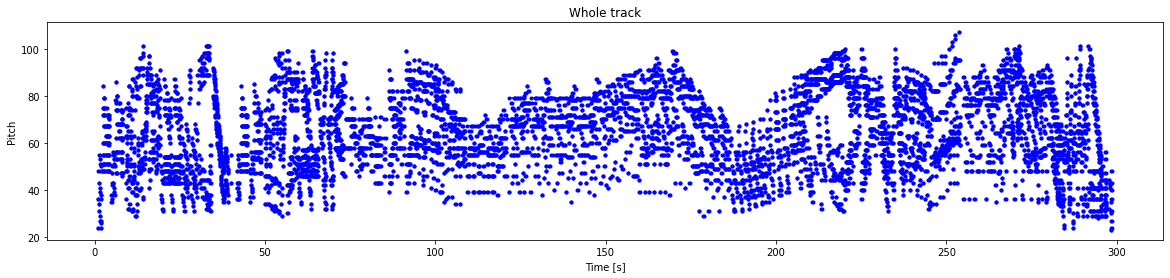

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

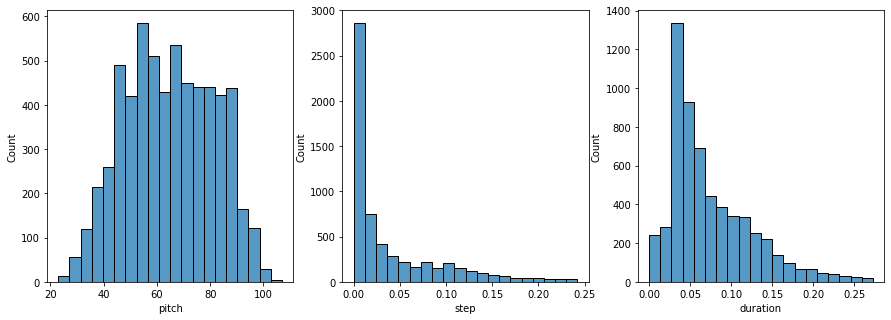

In [ ]:
plot_distributions(raw_notes)

### **Create a MIDI file**

Function to generate MIDI file from list of notes 

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and check for difference

In [ ]:
display_audio(example_pm)

### **Create Training dataset**

Extract notes from MIDI files and create a training dataset

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 16982


Creating a ```tf.data.Dataset``` from parsed notes

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Train model on batches of sequences of notes where each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

Using window() with size ```seq_length```, create the features and labels in this format.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set sequence length for each example and using **Hyperparameter tuning** experiment with different lengths to find optimal length for the data. 

In [ ]:
seq_length = 25
vocab_size = 128    # vocabulary size
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The model takes 100 notes as input as it's shape is ```(100, 1)``` to predict the following note as output

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.390625   0.         0.60546875]
 [0.296875   0.00520833 0.63151042]
 [0.484375   0.22135417 0.0703125 ]
 [0.5        0.09244792 0.09244792]
 [0.515625   0.09765625 0.0859375 ]
 [0.5234375  0.11328125 0.09244792]
 [0.5390625  0.1015625  0.046875  ]
 [0.515625   0.2109375  0.05208333]
 [0.5390625  0.18880208 0.05729167]
 [0.578125   0.19270833 0.07161458]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=79.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.010416666666666963>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.34635416666666696>}


Batch the examples & configure dataset for performance

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### **Create & Train model**

The model will have 3 outputs, one for each note variable. To get non negative value output, use a custom loss function based on mean squared error for ```step``` and ```duration```

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

```pitch``` loss is significantly greater than the ```step``` and ```duration``` lossess while testing ```model.evaluate()```. ```loss``` is the total loss computed by summation of all other losses and is currently dominated by ```pitch``` loss

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

264/264 [==============================] - 9s 22ms/step - loss: 5.0832 - duration_loss: 0.2075 - pitch_loss: 4.8473 - step_loss: 0.0285


{'duration_loss': 0.20746275782585144,
 'loss': 5.0832295417785645,
 'pitch_loss': 4.8472981452941895,
 'step_loss': 0.028469938784837723}

Use ```loss_weights``` argument during compiling the model to balance

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

```loss``` becomes weighted sum of individual losses

In [ ]:
model.evaluate(train_ds, return_dict=True)

264/264 [==============================] - 6s 18ms/step - loss: 0.4783 - duration_loss: 0.2075 - pitch_loss: 4.8473 - step_loss: 0.0285


{'duration_loss': 0.20746275782585144,
 'loss': 0.4782978296279907,
 'pitch_loss': 4.8472981452941895,
 'step_loss': 0.028469938784837723}

Train the model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
264/264 [==============================] - 12s 39ms/step - loss: 0.3654 - duration_loss: 0.1361 - pitch_loss: 4.1082 - step_loss: 0.0240
Epoch 2/50
264/264 [==============================] - 10s 40ms/step - loss: 0.3464 - duration_loss: 0.1276 - pitch_loss: 3.9133 - step_loss: 0.0232
Epoch 3/50
264/264 [==============================] - 10s 40ms/step - loss: 0.3427 - duration_loss: 0.1257 - pitch_loss: 3.8903 - step_loss: 0.0225
Epoch 4/50
264/264 [==============================] - 12s 47ms/step - loss: 0.3404 - duration_loss: 0.1245 - pitch_loss: 3.8749 - step_loss: 0.0222
Epoch 5/50
264/264 [==============================] - 10s 39ms/step - loss: 0.3385 - duration_loss: 0.1238 - pitch_loss: 3.8548 - step_loss: 0.0220
Epoch 6/50
264/264 [==============================] - 10s 39ms/step - loss: 0.3352 - duration_loss: 0.1225 - pitch_loss: 3.8280 - step_loss: 0.0213
Epoch 7/50
264/264 [==============================] - 10s 39ms/step - loss: 0.3338 - duration_loss: 0.1218 - pit

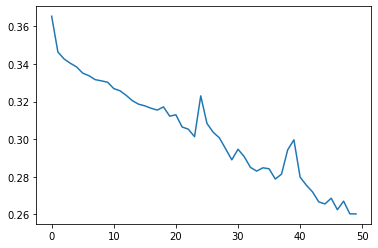

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### **Generate Notes**

Provide the model with a starting sequence of notes using the function given below.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

```temperature``` parameter controls the randomness of notes generated.

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Generate some notes

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,55,0.038824,0.149438,0.038824,0.188262
1,56,0.117590,0.536694,0.156414,0.693108
2,75,0.098758,0.671358,0.255172,0.926531
3,46,0.097933,0.702521,0.353105,1.055626
4,74,0.090733,0.678993,0.443838,1.122831
5,65,0.096852,0.700572,0.540690,1.241262
6,56,0.095405,0.703355,0.636095,1.339450
7,78,0.095626,0.720838,0.731721,1.452559
8,90,0.094472,0.710080,0.826193,1.536274
9,80,0.091123,0.689788,0.917316,1.607104


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualize the generated notes

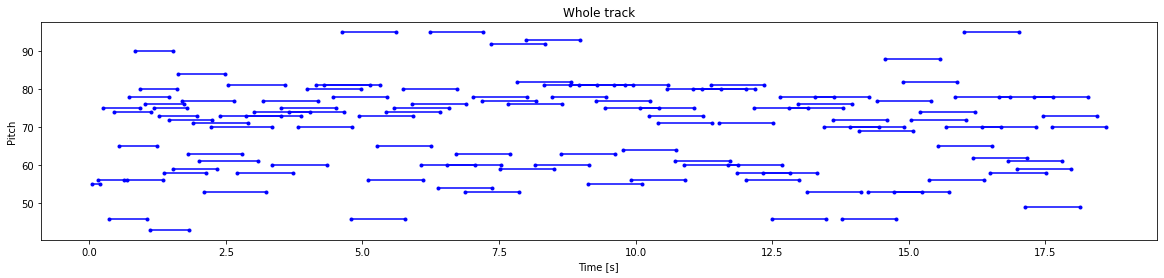

In [ ]:
plot_piano_roll(generated_notes)

Check distributions of ```pitch```, ```step``` & ```duration```

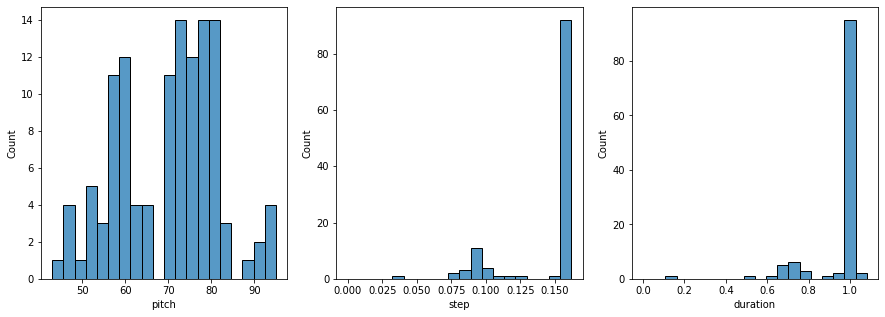

In [ ]:
plot_distributions(generated_notes)

Due to presence of feedback loop between model's outputs & inputs, the model tends to generate similar sequences of outputs to reduce Loss. ```step``` and ```duration``` use MSE loss whereas ```pitch``` can increase randomness by increasing ```temperature``` in ```predict_next_note```.